Importing necessary libraries

In [1]:
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Setting the hyperparameters

In [10]:
vocab_size=10000  #number of words as features
embedding_dim=16  #number of features representing a word
max_length=32  #maximum length of sequence
trunc_type='post'  #from where to remove the sentence if it is greater than max_length
padding_type='post'  #where to pad values in case of shorter sequences than longest
oov_token="<unique>"  #this will be assign to the words not present in corpus
training_size=20000  #length of our training set. Rest is taken as test set

Importing the json dataset

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2020-07-02 05:46:32--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 172.217.214.128, 108.177.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.08s   

2020-07-02 05:46:33 (71.5 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



Now that we have the dataset, it's time to read our data

In [25]:
with open("/tmp/sarcasm.json","r") as f:
    data=json.load(f)
sentences=[]  #an empty list so that we can store our sentences later
labels=[]  #a list to store labels 
for item in data:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])
training_set=sentences[0:training_size]  #take 20000 data points as training set
testing_set=sentences[training_size:]  #take remaining as test set
training_labels=labels[0:training_size]
test_labels=labels[training_size:]



Text preprocessing

In [22]:
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_token)
tokenizer.fit_on_texts(training_set)
word_index=tokenizer.word_index
training_sequences=tokenizer.texts_to_sequences(training_set)
training_padded=pad_sequences(training_sequences,maxlen=max_length,
                              padding=padding_type,truncating=trunc_type)

testing_sequences=tokenizer.texts_to_sequences(testing_set)
testing_padded=pad_sequences(testing_sequences,maxlen=max_length,
                              padding=padding_type,truncating=trunc_type)


In [33]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
test_labels = np.array(test_labels)

Create out neural network

In [28]:
from tensorflow.keras import Sequential
#create our model object of Sequential class for training 
model=Sequential([
                  tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length), #returns 2D array of feature vectors
                  tf.keras.layers.GlobalAveragePooling1D(),  #flattening the 2D array
                  tf.keras.layers.Dense(20,activation='relu'),  #use relu to avoid vanishing gradient descent 
                  tf.keras.layers.Dense(1,activation='sigmoid')  #outputs number b/w 0 and 1 denoting either class

])

Compile the model

In [34]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 16)            160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                340       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 160,361
Trainable params: 160,361
Non-trainable params: 0
_________________________________________________________________
None


Training the model

In [35]:
import numpy as np
history=model.fit(training_padded,training_labels,
                  epochs=20,
validation_data=(testing_padded,test_labels),verbose=2)

Epoch 1/20
625/625 - 3s - loss: 0.5801 - accuracy: 0.6883 - val_loss: 0.4135 - val_accuracy: 0.8344
Epoch 2/20
625/625 - 3s - loss: 0.3268 - accuracy: 0.8718 - val_loss: 0.3473 - val_accuracy: 0.8553
Epoch 3/20
625/625 - 3s - loss: 0.2452 - accuracy: 0.9043 - val_loss: 0.3411 - val_accuracy: 0.8568
Epoch 4/20
625/625 - 3s - loss: 0.1992 - accuracy: 0.9255 - val_loss: 0.3548 - val_accuracy: 0.8554
Epoch 5/20
625/625 - 3s - loss: 0.1656 - accuracy: 0.9385 - val_loss: 0.3810 - val_accuracy: 0.8478
Epoch 6/20
625/625 - 3s - loss: 0.1416 - accuracy: 0.9487 - val_loss: 0.4060 - val_accuracy: 0.8487
Epoch 7/20
625/625 - 3s - loss: 0.1213 - accuracy: 0.9584 - val_loss: 0.4576 - val_accuracy: 0.8363
Epoch 8/20
625/625 - 2s - loss: 0.1063 - accuracy: 0.9644 - val_loss: 0.5047 - val_accuracy: 0.8320
Epoch 9/20
625/625 - 3s - loss: 0.0914 - accuracy: 0.9707 - val_loss: 0.5228 - val_accuracy: 0.8359
Epoch 10/20
625/625 - 2s - loss: 0.0801 - accuracy: 0.9740 - val_loss: 0.6239 - val_accuracy: 0.8235

It's time visualize the data

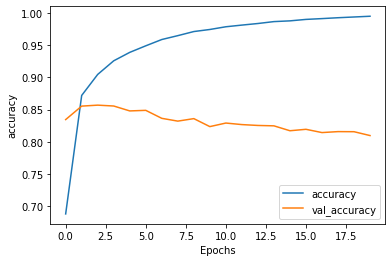

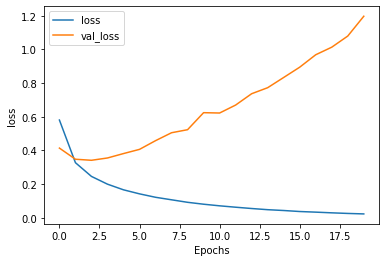

In [36]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [38]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_set[2])
print(labels[2])

former <unique> store clerk sues over secret 'black <unique> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [39]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 16)


Saving our embeddings to project it


In [49]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [48]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
#predict
sentence=["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences=tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[8.0308491e-01]
 [1.3848467e-07]]
